In [1]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
validation_split_seed = 3

In [0]:
!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

In [3]:
def prepare_file():
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  drive.CreateFile({'id':'1Z3YUgLeYLxYZGDGF4kWAOjgGg7N9BzEi'}).GetContentFile("htt_features.pkl")

In [4]:
def load_data():
    with open("htt_features.pkl", "rb") as input:
        legs, jets, global_params, properties =pickle.load(input)
    print("no of legs: ", len(legs))
    print("no of jets: ", len(jets))
    print("params: ", global_params.keys(), properties.keys())
    return legs, jets, global_params, properties


In [5]:
#preparing flat data and target numpy arrays
def prepare_data(legs, jets, global_params, properties, to_predict):
    data = []
    def add_legs():
        for leg in legs:
            for prop in leg:
                data.append(prop)
    def add_jets():
        for leg in jets:
            for prop in leg:
                data.append(prop)
    def add_globals(labels):
        for key in global_params:
            if key!=to_predict and key in labels:
                data.append(global_params[key])
    def add_properties(labels):
        for key in properties:
            if key!=to_predict and key in labels:
                data.append(properties[key])
    add_legs()
    add_jets()
    add_globals(global_params.keys())
    add_properties(properties.keys())
    data = np.array(data)
    data = np.transpose(data)
    
    if to_predict in global_params.keys(): target = np.array(global_params[to_predict])
    elif to_predict in properties.keys(): target = np.array(properties[to_predict])
    else:
        raise ValueError("`to_predict`: (" + to_predict + ") does not match any key")
    target = np.transpose(target)
    print("data.shape : ", data.shape)
    print("target.shape : ", target.shape)
    return data, target


In [6]:
#model definition
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(128, input_dim = data.shape[1], activation="relu"))
    model.add(tf.keras.layers.Dense(64, input_dim = data.shape[1], activation="linear"))
    model.add(tf.keras.layers.Dense(32, input_dim = data.shape[1], activation="linear"))
    model.add(tf.keras.layers.Dense(1, activation="linear"))
    # beta1 is decay added to improve stability
    model.compile(optimizer=tf.train.AdamOptimizer(beta1=0.99),
                  loss='mse')
    print(model.summary())
    return model

In [7]:
def plot_preds(x_train, x_val, y_train, y_val, model):
    y_train_pred = model.predict(x_train)
    plt.scatter(y_train,y_train_pred, label="training")
    y_val_pred = model.predict(x_val)
    plt.scatter(y_val,model.predict(x_val), label="validation")
    plt.plot(y_train, y_train)
    plt.legend()
    plt.title("mass predicted vs true distribution")
    plt.xlabel("target mass")
    plt.ylabel("predicted mass")
    plt.show()
    
    y_pred = np.concatenate((y_train_pred, y_val_pred), axis=0)[:,0]
    y_all = np.concatenate((y_train, y_val), axis=0)
    error = (y_pred - y_all)/y_all
    plt.hist(error, bins=60, range=(-2,2))
    plt.xlabel("(y_pred - y_target)/y_target")
    plt.title("relative prediction error")
    plt.show()

In [8]:
history = np.empty((2,0))
def clean_history():
    global history
    history = np.empty((2,0))
def update_history(h):
    global history
    history = np.append(history, [h.history['loss'], h.history['val_loss']],axis=1)
def plot_history():
    plt.plot(history[0], label='train')
    plt.plot(history[1], label='validation')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [10]:
#data preparation

prepare_file()
legs, jets, global_params, properties = load_data()
to_predict = "genMass"
data, target = prepare_data(legs, jets, global_params, properties, to_predict)
#splitting data between train and validation set
x_train, x_val, y_train, y_val = train_test_split(data, target, train_size=0.9, random_state=validation_split_seed)

('no of legs: ', 2)
('no of jets: ', 0)
('params: ', ['covMET10', 'genMass', 'covMET11', 'higgsPT', 'higgsMassTrans', 'visMass', 'covMET00', 'covMET01'], ['leg_2_PDGId', 'leg_1_PDGId', 'leg_2_decayMode'])
('data.shape : ', (66583, 18))
('target.shape : ', (66583,))


/home/przemek/.local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [0]:
# training parameters

plot_steps = 10
epochs_per_plot_step = 5

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2432      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 12,801
Trainable params: 12,801
Non-trainable params: 0
_________________________________________________________________
None


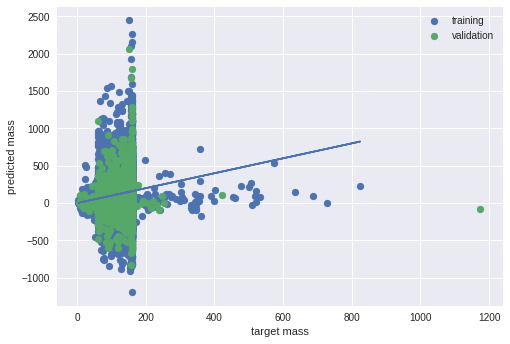

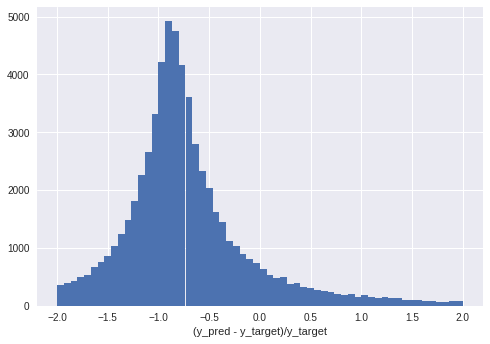

Train on 59924 samples, validate on 6659 samples
Epoch 1/5
59924/59924 [==============================] - 1s 19us/step - loss: 961.7490 - val_loss: 612.4543
Epoch 2/5
59924/59924 [==============================] - 1s 17us/step - loss: 559.6776 - val_loss: 567.2514
Epoch 3/5
59924/59924 [==============================] - 1s 17us/step - loss: 570.6244 - val_loss: 573.5629
Epoch 4/5
59924/59924 [==============================] - 1s 17us/step - loss: 533.5984 - val_loss: 555.7942
Epoch 5/5
59924/59924 [==============================] - 1s 17us/step - loss: 528.9779 - val_loss: 542.4461


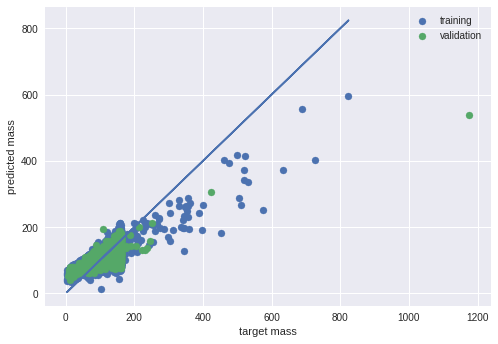

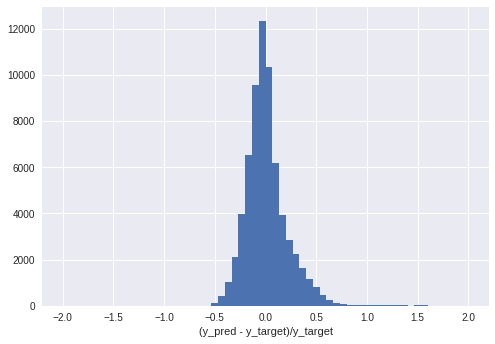

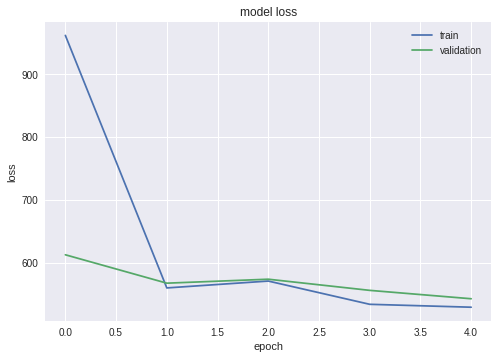

Train on 59924 samples, validate on 6659 samples
Epoch 1/5
59924/59924 [==============================] - 1s 17us/step - loss: 492.3321 - val_loss: 521.5429
Epoch 2/5
59924/59924 [==============================] - 1s 17us/step - loss: 473.6836 - val_loss: 499.5142
Epoch 3/5
59924/59924 [==============================] - 1s 17us/step - loss: 464.7089 - val_loss: 481.6437
Epoch 4/5
59924/59924 [==============================] - 1s 17us/step - loss: 467.9932 - val_loss: 482.5004
Epoch 5/5
59924/59924 [==============================] - 1s 17us/step - loss: 440.9092 - val_loss: 464.3535


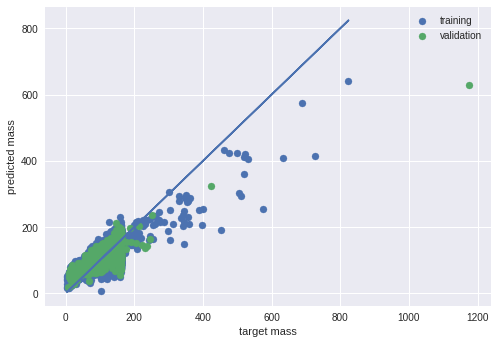

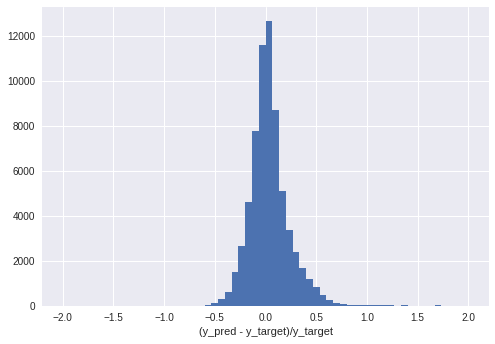

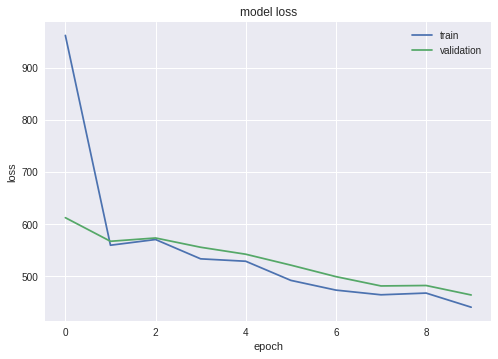

Train on 59924 samples, validate on 6659 samples
Epoch 1/5
59924/59924 [==============================] - 1s 17us/step - loss: 436.3974 - val_loss: 467.8157
Epoch 2/5
59924/59924 [==============================] - 1s 17us/step - loss: 430.6000 - val_loss: 439.2641
Epoch 3/5
59924/59924 [==============================] - 1s 17us/step - loss: 415.3048 - val_loss: 434.0722
Epoch 4/5
59924/59924 [==============================] - 1s 17us/step - loss: 410.7802 - val_loss: 456.2983
Epoch 5/5
59924/59924 [==============================] - 1s 17us/step - loss: 400.3454 - val_loss: 424.7381


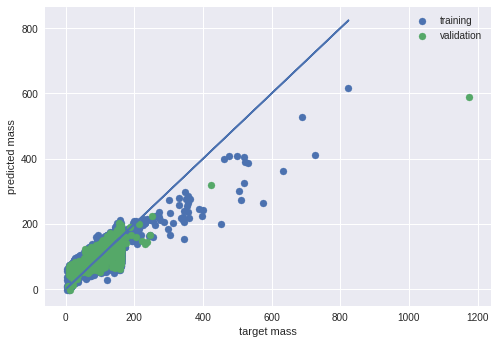

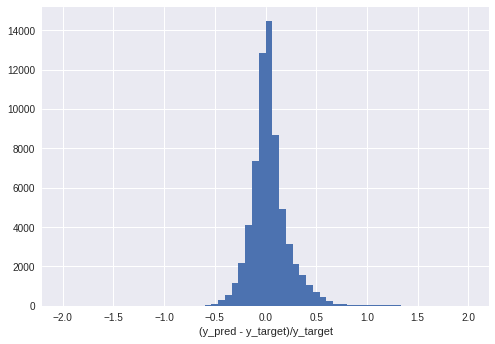

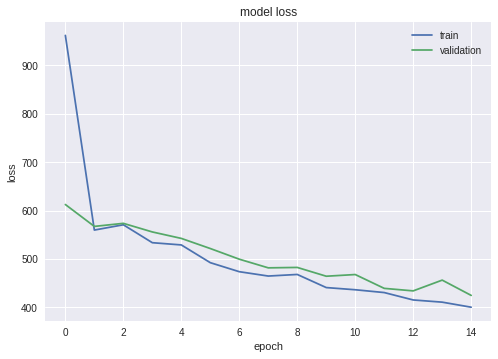

Train on 59924 samples, validate on 6659 samples
Epoch 1/5
59924/59924 [==============================] - 1s 17us/step - loss: 404.2094 - val_loss: 458.1627
Epoch 2/5
59924/59924 [==============================] - 1s 17us/step - loss: 394.4484 - val_loss: 436.5600
Epoch 3/5
59924/59924 [==============================] - 1s 17us/step - loss: 390.3000 - val_loss: 428.9102
Epoch 4/5
59924/59924 [==============================] - 1s 17us/step - loss: 384.7360 - val_loss: 411.1268
Epoch 5/5
59924/59924 [==============================] - 1s 17us/step - loss: 382.1994 - val_loss: 428.0438


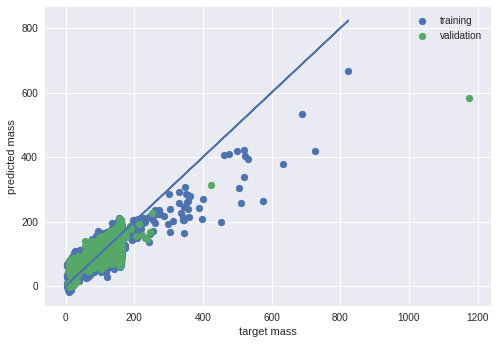

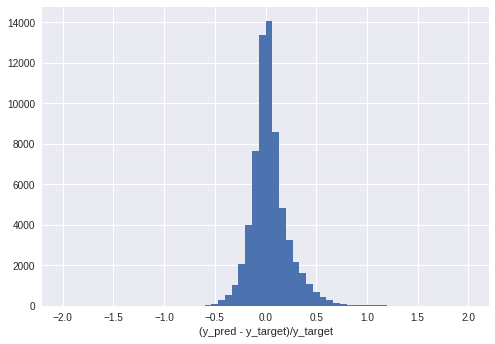

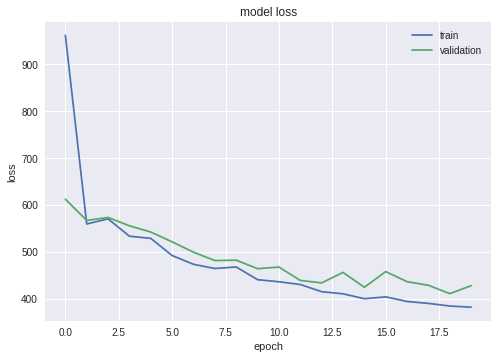

Train on 59924 samples, validate on 6659 samples
Epoch 1/5
59924/59924 [==============================] - 1s 17us/step - loss: 383.6307 - val_loss: 429.2635
Epoch 2/5
59924/59924 [==============================] - 1s 17us/step - loss: 381.5251 - val_loss: 455.3063
Epoch 3/5
59924/59924 [==============================] - 1s 17us/step - loss: 382.9398 - val_loss: 418.0201
Epoch 4/5
59924/59924 [==============================] - 1s 17us/step - loss: 378.3255 - val_loss: 399.3237
Epoch 5/5
59924/59924 [==============================] - 1s 17us/step - loss: 378.7091 - val_loss: 406.5887


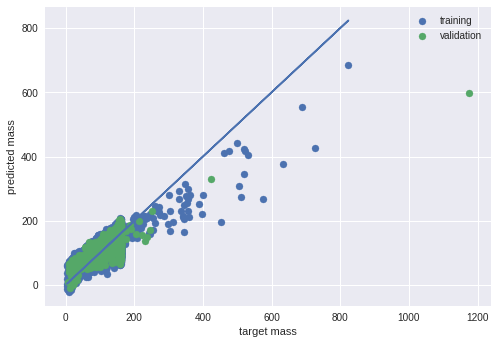

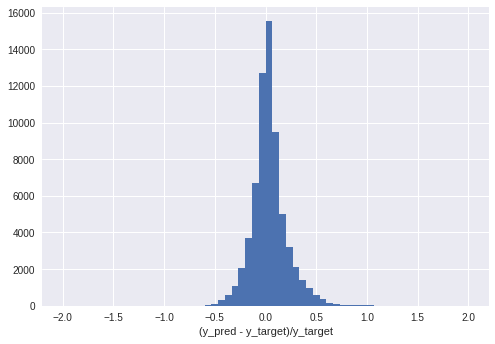

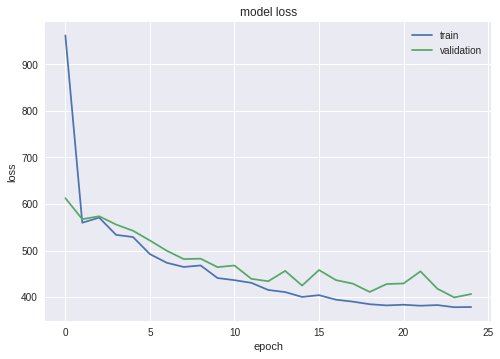

Train on 59924 samples, validate on 6659 samples
Epoch 1/5
59924/59924 [==============================] - 1s 17us/step - loss: 371.5368 - val_loss: 419.7012
Epoch 2/5
59924/59924 [==============================] - 1s 17us/step - loss: 375.3208 - val_loss: 405.1475
Epoch 3/5
59924/59924 [==============================] - 1s 17us/step - loss: 369.4065 - val_loss: 397.1280
Epoch 4/5
59924/59924 [==============================] - 1s 17us/step - loss: 368.7187 - val_loss: 388.3491
Epoch 5/5
59924/59924 [==============================] - 1s 17us/step - loss: 369.5947 - val_loss: 383.4419


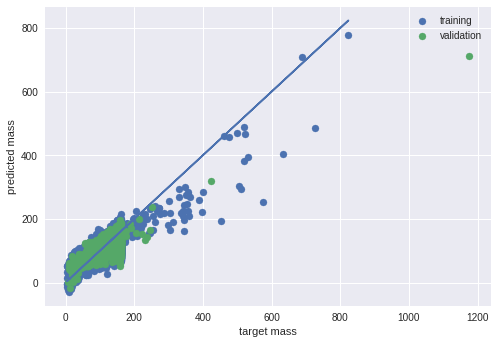

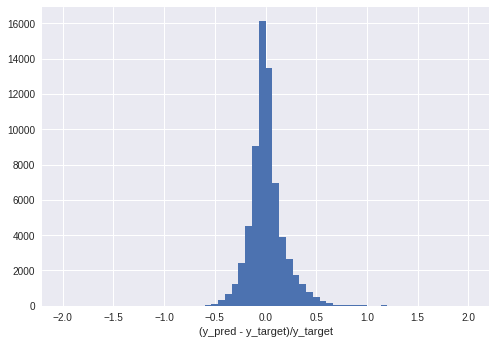

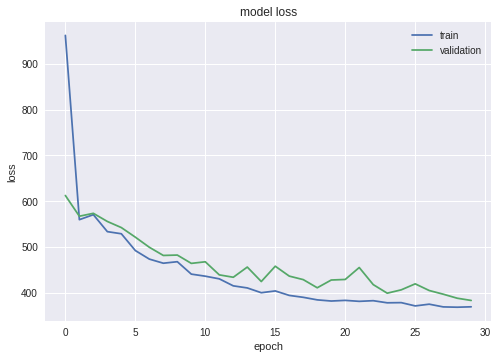

Train on 59924 samples, validate on 6659 samples
Epoch 1/5
59924/59924 [==============================] - 1s 19us/step - loss: 368.6154 - val_loss: 395.5533
Epoch 2/5
59924/59924 [==============================] - 1s 19us/step - loss: 371.9473 - val_loss: 384.6125
Epoch 3/5
59924/59924 [==============================] - 1s 19us/step - loss: 365.1428 - val_loss: 377.4828
Epoch 4/5
59924/59924 [==============================] - 1s 19us/step - loss: 365.1219 - val_loss: 370.3350
Epoch 5/5
59924/59924 [==============================] - 1s 19us/step - loss: 362.8614 - val_loss: 368.0804


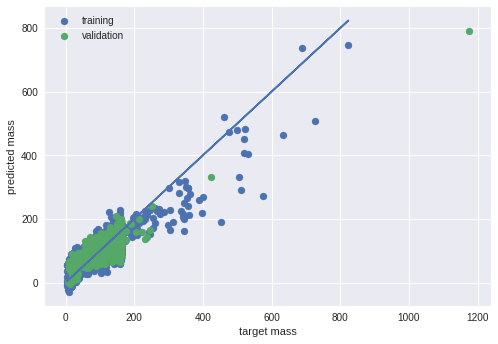

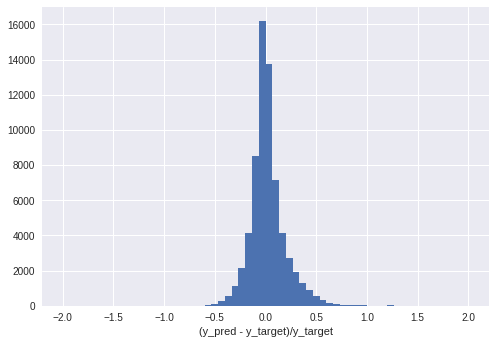

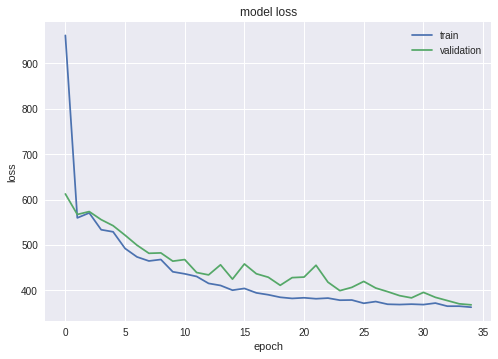

Train on 59924 samples, validate on 6659 samples
Epoch 1/5
59924/59924 [==============================] - 1s 18us/step - loss: 359.7305 - val_loss: 365.3423
Epoch 2/5
59924/59924 [==============================] - 1s 18us/step - loss: 361.1893 - val_loss: 376.0404
Epoch 3/5
59924/59924 [==============================] - 1s 18us/step - loss: 361.4816 - val_loss: 363.9133
Epoch 4/5
59924/59924 [==============================] - 1s 18us/step - loss: 356.6001 - val_loss: 355.8598
Epoch 5/5
59924/59924 [==============================] - 1s 18us/step - loss: 359.5189 - val_loss: 359.5508


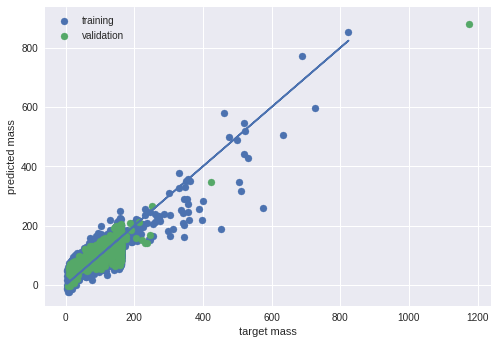

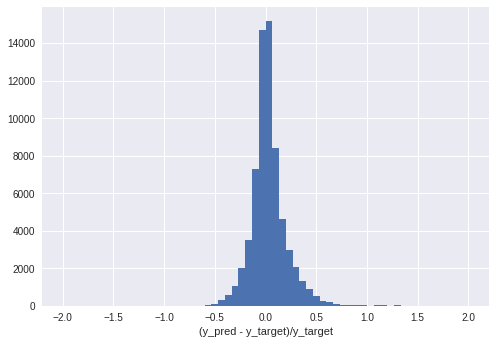

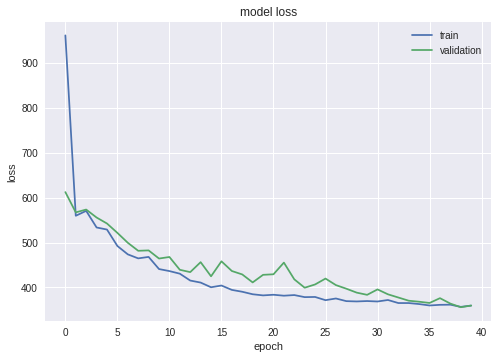

Train on 59924 samples, validate on 6659 samples
Epoch 1/5
59924/59924 [==============================] - 1s 17us/step - loss: 358.7311 - val_loss: 356.7035
Epoch 2/5
59924/59924 [==============================] - 1s 17us/step - loss: 352.8214 - val_loss: 359.9042
Epoch 3/5
59924/59924 [==============================] - 1s 17us/step - loss: 351.0927 - val_loss: 370.3429
Epoch 4/5
59924/59924 [==============================] - 1s 17us/step - loss: 362.5445 - val_loss: 360.2351
Epoch 5/5
59924/59924 [==============================] - 1s 17us/step - loss: 352.8078 - val_loss: 364.8460


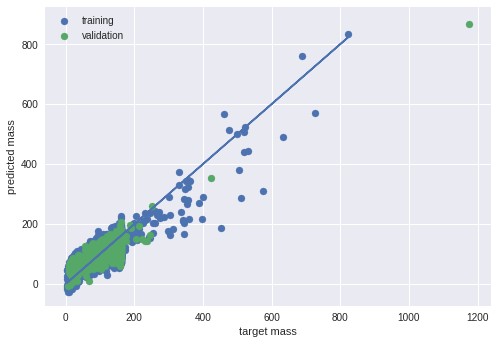

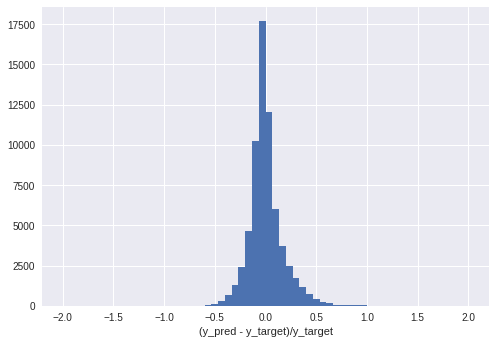

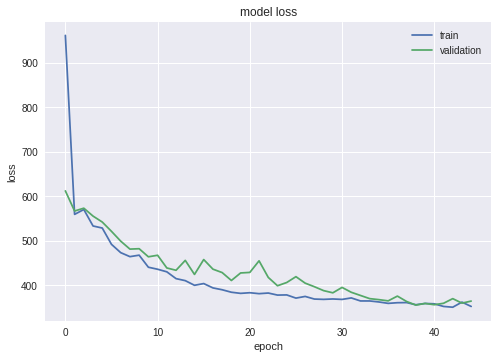

Train on 59924 samples, validate on 6659 samples
Epoch 1/5
59924/59924 [==============================] - 1s 17us/step - loss: 353.2827 - val_loss: 385.2792
Epoch 2/5
59924/59924 [==============================] - 1s 17us/step - loss: 357.1791 - val_loss: 354.7142
Epoch 3/5
59924/59924 [==============================] - 1s 17us/step - loss: 354.0573 - val_loss: 360.7102
Epoch 4/5
59924/59924 [==============================] - 1s 17us/step - loss: 351.7014 - val_loss: 362.2252
Epoch 5/5
59924/59924 [==============================] - 1s 17us/step - loss: 353.7248 - val_loss: 353.1689


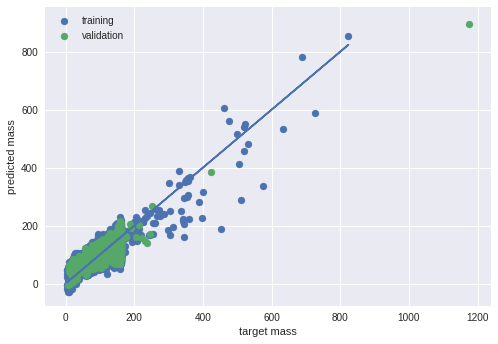

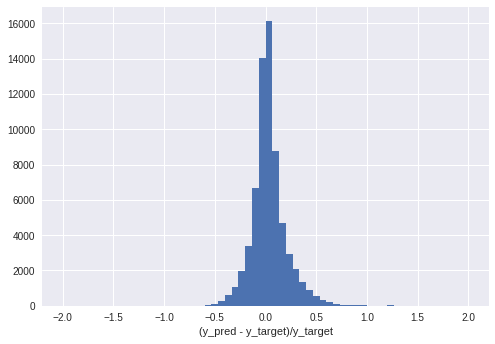

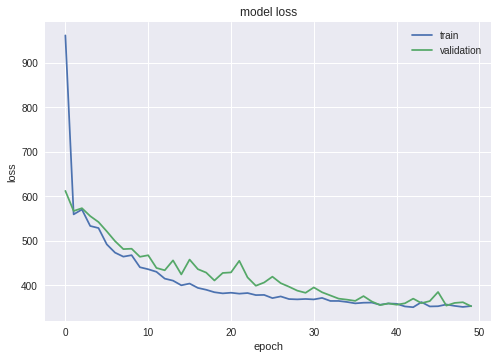

In [12]:
#training and plotting

model = get_model()
clean_history()
plot_preds(x_train, x_val, y_train, y_val, model)
for plot_step in range(plot_steps):
    h = model.fit(x=x_train, y=y_train, epochs=epochs_per_plot_step, verbose=1, batch_size=64, callbacks=None, validation_data=(x_val,y_val))
    plot_preds(x_train, x_val, y_train, y_val, model)
    update_history(h)
    plot_history()